## Introduction

In this project, we will analyze the spread of the new corona virus (nCov). We will use two datasets:
    - The John Hopkins University's dataset which contains aggregated daily data for confirmed cases, deaths and recovered patients. 
    https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
    - The DXY.cn's google sheet which contains information of about 1000 patients. 
    https://docs.google.com/spreadsheets/d/1jS24DjSPVWa4iuxuD4OAXrE3QeI8c9BC1hSlqr-NMiU/edit#gid=1187587451


Son Huynh
29.02.2020

About getting dataset:

The reddit's datasets group is a good place to look for datasets. For example, you can check out useful sources for nCov data from here: https://www.reddit.com/r/datasets/comments/exnzrd/coronavirus_datasets/

Reddit in general is great for getting tips and browsing discussions. Some of my favorite subreddits are dataisbeautiful, datascience, MachineLearning.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

In [3]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_cured = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

Let's take a look at the case time series first

In [4]:
case = pd.read_csv(url_case, index_col=[0, 1, 2, 3])
case

HTTPError: HTTP Error 404: Not Found

Since the John Hopkins dataset contains only aggregated data, we need to transform it into a format that allows us to answer more questions. You can see the ideal dataframe structure in the picture below.

You will need to:
- Stack the dataframe so that each row represents one date in a location. 
- Remove the rows where the cumulative number of cases is zero.
- Make a new column `location` to combine `prov_state` and `country`.
- Make a new column `new_case` to derive the new case number from cumulative case number.
- Convert the date column to datetime object.

After transforming data for number of cases, you can do the same for number of deaths and cureds (or write a function to transform 3 datasets). Then you can use `pd.merge()` to merge them into one dataframe. Hint: try merging `case` with `death` first and then merge that with `cured`. You should use a `left` merge on `['location', 'prov_state', 'country', 'lat', 'long', 'date']` columns

![title](desired_format.png)

In [ ]:
case = case.stack()
case = case.reset_index()
case

In [ ]:
case = case.rename(columns={'level_4':'date'})
case = case.rename(columns={0:'cum_case'})
case = case.rename(columns={"Province/State":"prov_state","Country/Region":"country","Lat":"lat","Long":"long"})
case

In [ ]:
case = case[case.cum_case != 0]
case

In [ ]:
case["location"]=np.where(case.prov_state.isnull(),case.country,case.prov_state)
case.head()

In [ ]:
case["new_case"] = case.cum_case.diff(1)
case.new_case = case.new_case.fillna(case.cum_case)
case.head(3)

In [ ]:
case = case[["location","prov_state","country","lat","long","date","cum_case","new_case"]]
case.tail()

In [ ]:
case.date = pd.to_datetime(case.date)
case.head(1)

In [5]:
case[case.new_case<0]

NameError: name 'case' is not defined

In [6]:
def load_csv(url, measure_name):
    df = pd.read_csv(url, index_col=[0, 1, 2, 3])
    df = df.stack()
    df = df.reset_index()
    
    cum = 'cum_' + measure_name
    df.columns = ['prov_state', 'country', 'lat', 'long', 'date', cum]
    
    df.date = pd.to_datetime(df.date, format='%m/%d/%y')
    
    df = df[df[cum] != 0]
    
    df['location'] = np.where(df.prov_state.isnull(), df.country, df.prov_state)
    
    new = 'new_' + measure_name
    df[new] = df.groupby('location')[cum].diff(1)
    df[new] = df[new].fillna(df[cum])
    
    return df[['location', 'prov_state', 'country', 'lat', 'long', 'date', cum, new]]

In [7]:
case = load_csv(url_case, 'case')
death = load_csv(url_death, 'death')
cured = load_csv(url_cured, 'cured')

HTTPError: HTTP Error 404: Not Found

In [8]:
corona19=pd.merge(case,death, how="left",on=["location","prov_state","country","lat","long","date",])
corona19=pd.merge(corona19,cured, how="left",on=["location","prov_state","country","lat","long","date",])

NameError: name 'case' is not defined

In [9]:
corona19.head(3)

NameError: name 'corona19' is not defined

In [10]:
corona19.groupby("location").agg({"cum_case":"sum"})

NameError: name 'corona19' is not defined

### Time series : Number of cases in Finland

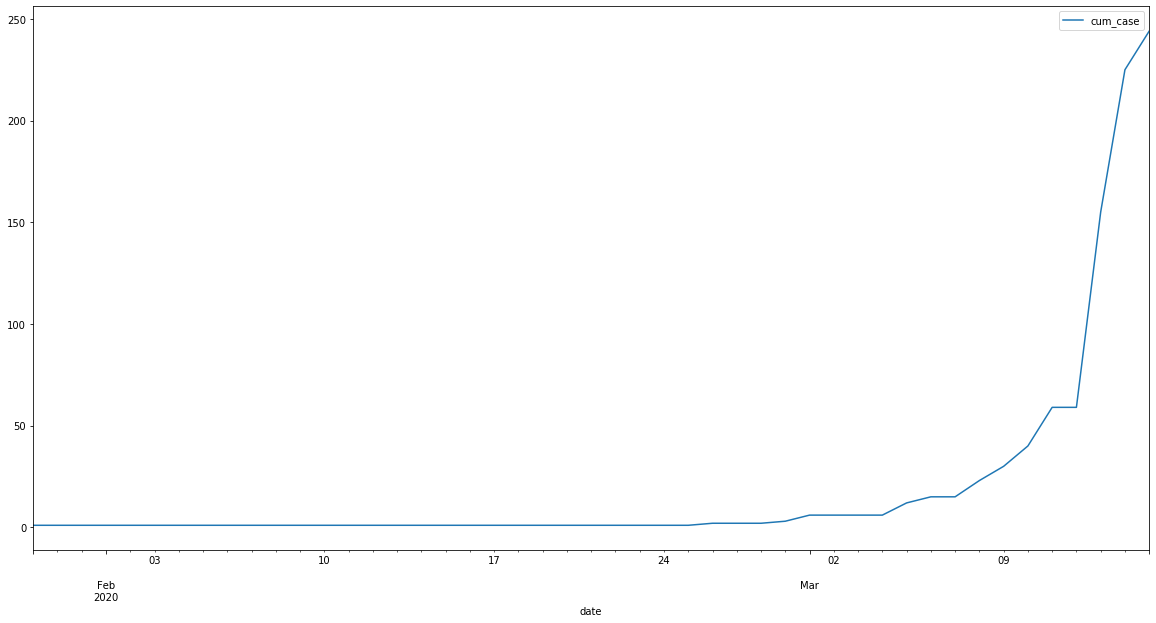

In [18]:
corona19_Fin = corona19[(corona19.location == "Finland")]
corona19_Fin.groupby("date").agg({'cum_case': 'sum'}).plot(kind='line', figsize=(20,10))

# Top 10 locations with cases

In [34]:
corona19_last_update = corona19[corona19.date == '2020-03-15']
sorted_df = corona19_last_update.sort_values(by=['cum_case'], ascending=False).head(10)

In [35]:
sorted_df.index.values
sorted_df.set_index("location",drop=True,inplace=True)

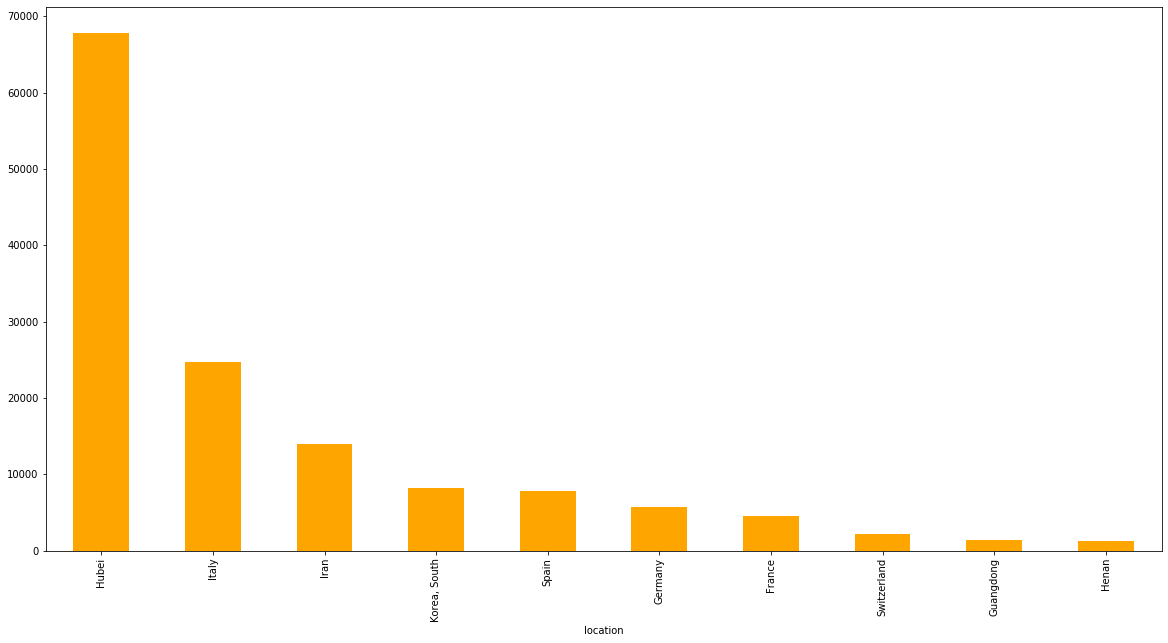

In [36]:
sorted_df['cum_case'].plot(kind="bar",figsize=(20,10), color="orange")

# Top 10 countries with most deaths

In [37]:
sorted_df2=corona19.groupby("country").agg({"cum_death":"max"}).sort_values(by=["cum_death"], ascending=False).head(10)

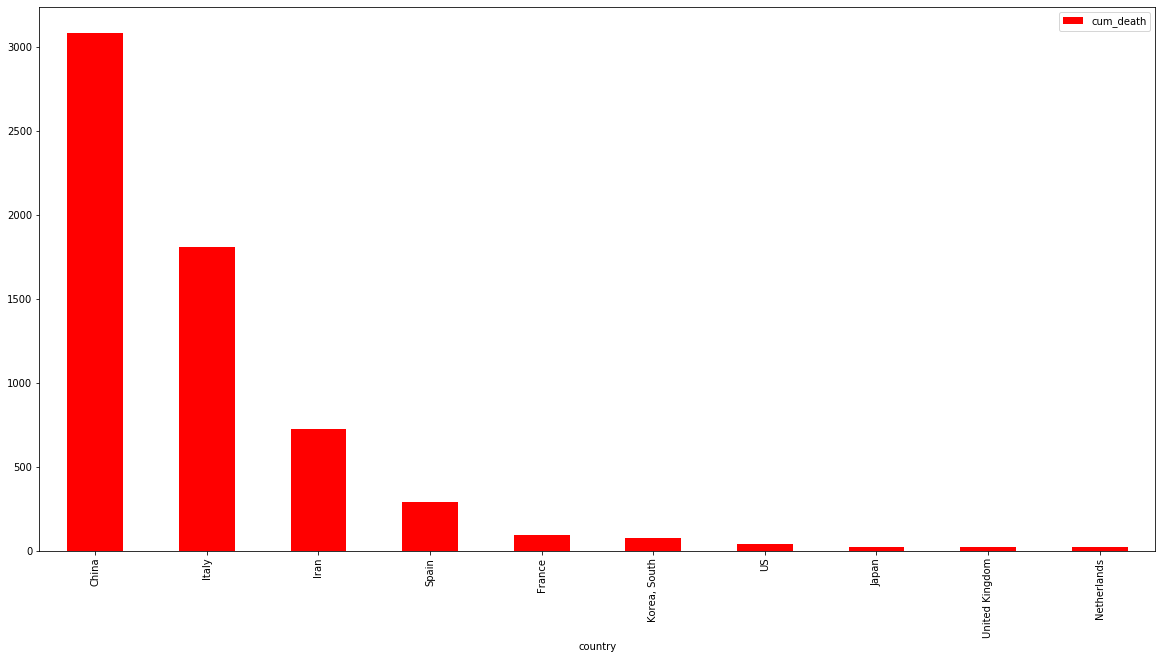

In [38]:
sorted_df2.plot(kind="bar", figsize=(20,10), color="red")

# Comparison of the number of cases in the northern countries 
#NOTE: I did not manage to merge all the countries into a single chart


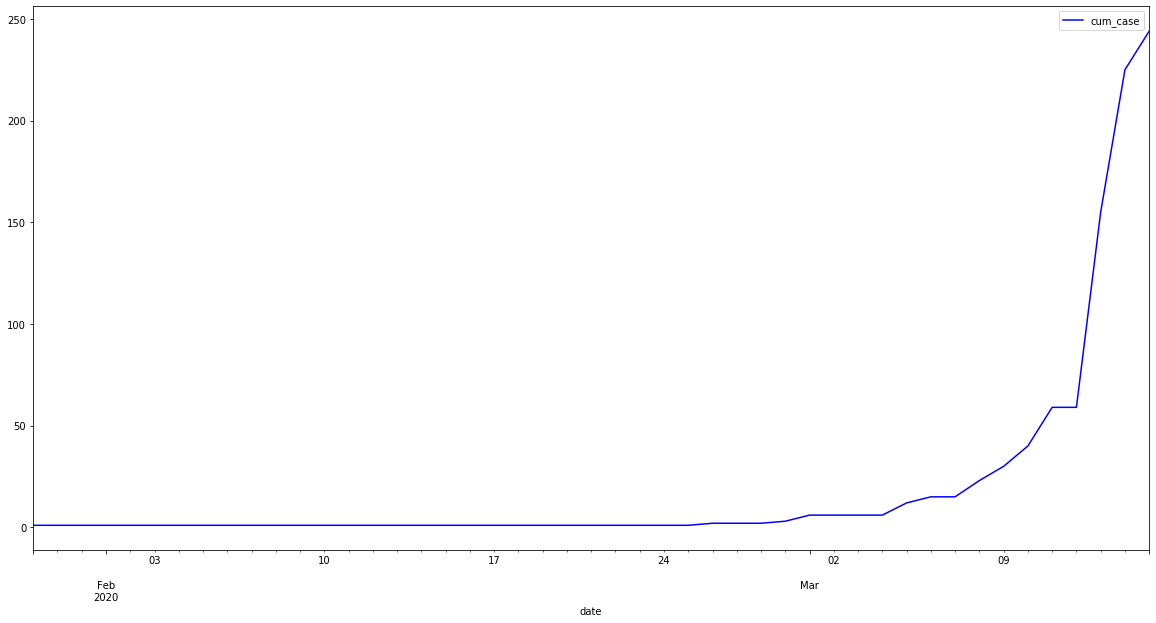

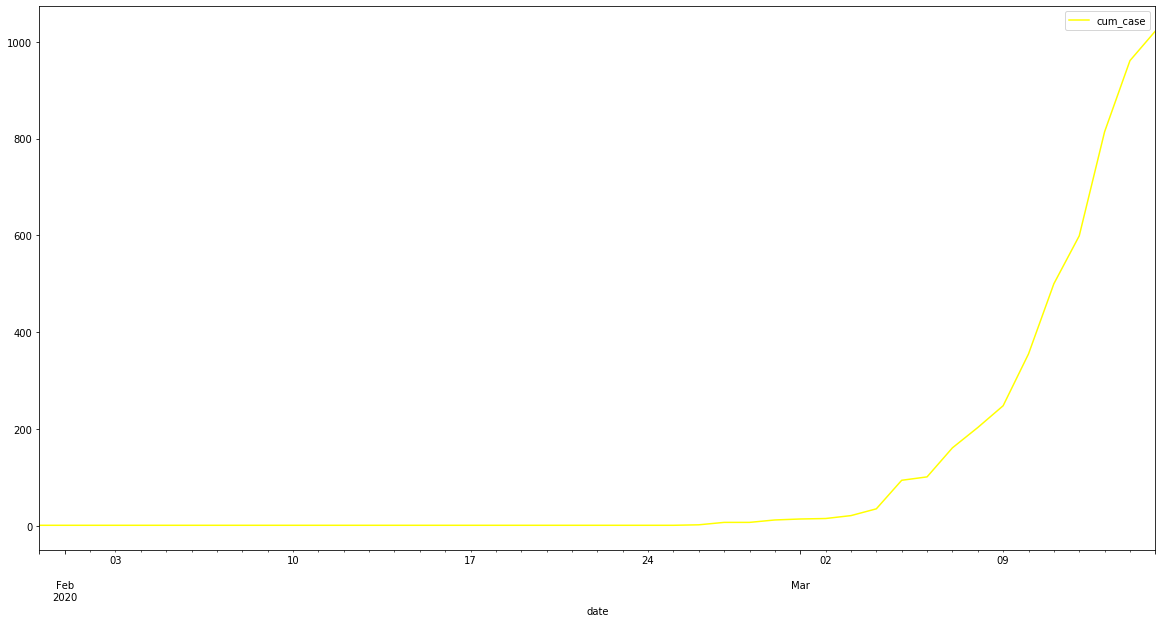

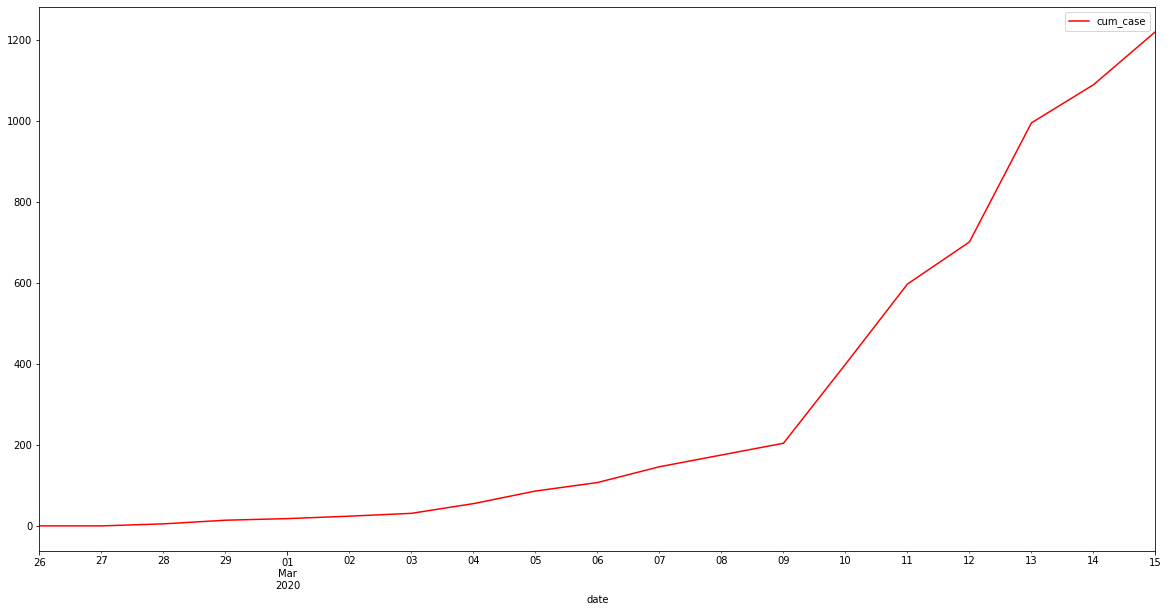

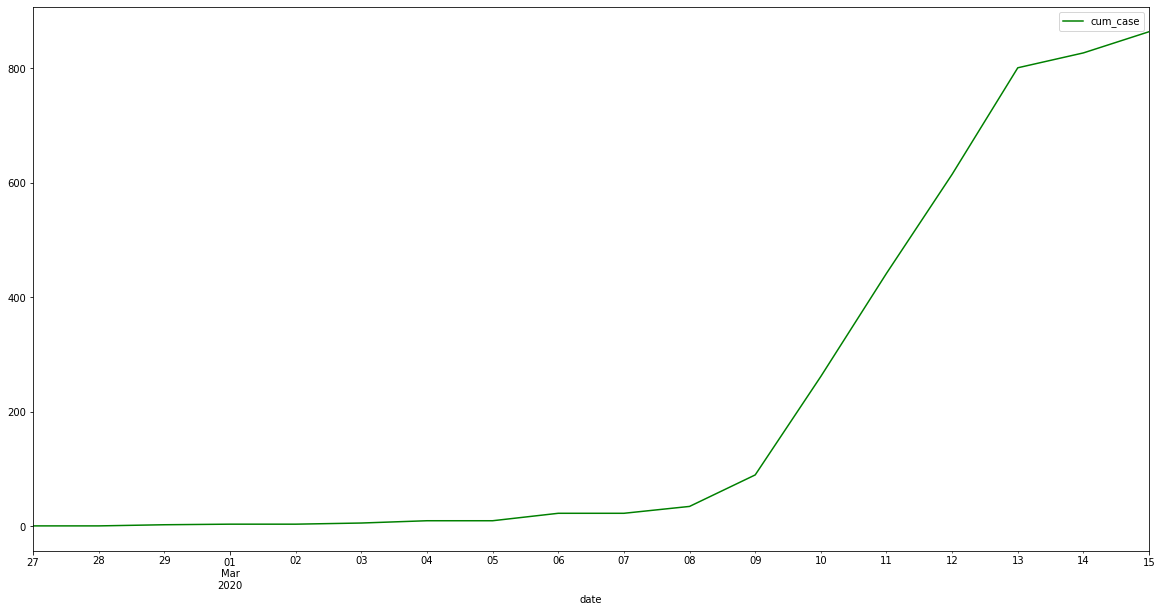

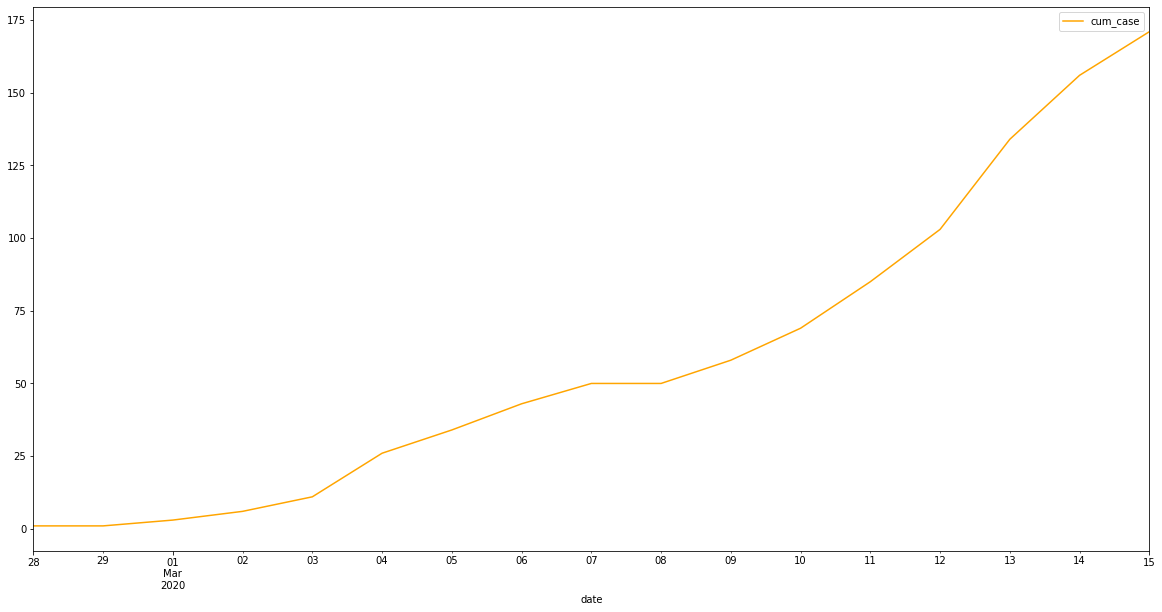

In [39]:
corona19_Fin = corona19[(corona19.location == "Finland")] #choose only rows for finland
corona19_Fin.groupby("date").agg({'cum_case': 'sum'}).plot(kind="line", figsize=(20,10), color="blue") #show for each date the cum amount of cases

corona19_Swe = corona19[(corona19.location == "Sweden")]
corona19_Swe.groupby("date").agg({'cum_case': 'sum'}).plot(kind="line", figsize=(20,10), color="yellow")

corona19_Nor = corona19[(corona19.location == "Norway")]
corona19_Nor.groupby("date").agg({'cum_case': 'sum'}).plot(kind="line", figsize=(20,10), color="red")

corona19_Den = corona19[(corona19.location == "Denmark")]
corona19_Den.groupby("date").agg({'cum_case': 'sum'}).plot(kind="line", figsize=(20,10), color="green")

corona19_Ice = corona19[(corona19.location == "Iceland")]
corona19_Ice.groupby("date").agg({'cum_case': 'sum'}).plot(kind="line", figsize=(20,10), color="orange")

#nordic_countries = pd.concat([corona19_Fin,corona19_Swe,corona19_Nor,corona19_Den,corona19_Ice])
#sns.lineplot(data="nordic_countries", figsize=(20,10), hue="country")